In [1]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp

import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_calcium_base as pl


In [2]:

srate = 30. # points/frames per second
duration = 500 # in seconds
rate = 10 # how much your neuron should spike
environment_edges = [[10,30],[10,50]] # in cm [[x_min,x_max],[y_min,y_max]]

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_random_walk(input_srate = srate,input_total_Time = duration,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = timevector.shape[0]

spike_times = cs_model.generate_poisson_spikes(rate, duration, srate=1000)
spike_times_idx = (spike_times*srate).astype(int)

# place cell with one field: x_center and y_center is the location of the place field in the environment; s is the field extension
modulated_spike_times_idx = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,spike_times_idx,x_center = 20,y_center = 35, s = 2)

# grid cell with several fields
# modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)
# modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 90, s = 5)
# modulated_timestamps4 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 90, s = 5)
# modulated_timestamps5 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3,modulated_timestamps4,modulated_timestamps5]))

# if you want to control for the amount of spikes, set a fixed value for spikes
# num_of_spikes = 1000
# modulated_timestamps = np.sort(np.random.choice(modulated_timestamps,num_of_spikes,replace=False))

calcium_imag,timevector = cs_model.generate_calcium_signal(modulated_spike_times_idx,total_points,srate,noise_level = 0.01, b = 5.)
calcium_events = modulated_spike_times_idx.shape[0]
peaks_idx = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))


IndexError: arrays used as indices must be of integer (or boolean) type

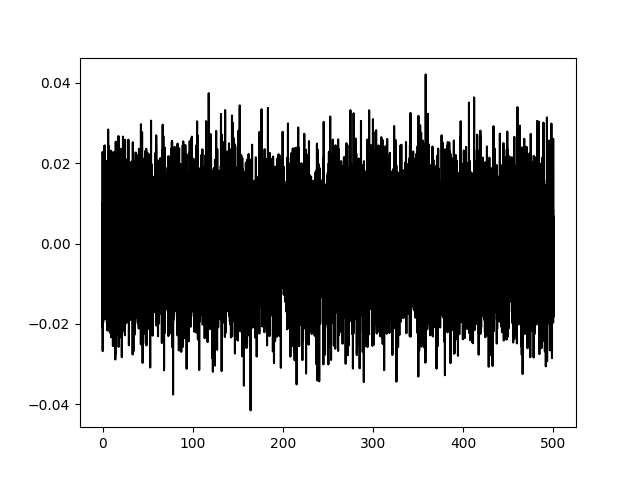

In [3]:

plt.figure()
plt.plot(timevector, calcium_imag,'k')
plt.eventplot(timevector[modulated_spike_times_idx],color='red')
plt.show()


In [ ]:

plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k')
plt.plot(x_coordinates[modulated_spike_times_idx],y_coordinates[modulated_spike_times_idx],color = 'red',linestyle='',marker='.',markersize=6)
# plt.gca().set_aspect('equal', 'box')
plt.show()


In [ ]:
# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
srate = 1/np.nanmean(np.diff(timevector))

signal_type = 'Raw'
input_signal = hf.preprocess_signal(calcium_imag,srate,signal_type)

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # x bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shift_time'] = 200
input_dict['num_cores'] = 30
input_dict['num_surrogates'] = 60
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['smoothing_size'] = 2
input_dict['nbins_cal'] = 10
input_dict['percentile_threshold'] = 95
input_dict['min_num_of_pixels'] = 4

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    place_cell = pl.PlaceCell(**input_dict)
    place_cell_output = place_cell.main(input_signal,timevector,x_coordinates,y_coordinates)


In [11]:
place_cell_output.keys()


dict_keys(['place_field', 'place_field_smoothed', 'place_field_shuffled', 'place_field_smoothed_shuffled', 'mutual_info_distribution', 'mutual_info_distribution_bezzi', 'mutual_info_distribution_shuffled', 'mutual_info_distribution_bezzi_shuffled', 'occupancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'events_amplitude', 'place_field_identity', 'num_of_islands', 'islands_x_max', 'islands_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'mutual_info_kullback_leibler_original', 'mutual_info_kullback_leibler_shuffled', 'mutual_info_kullback_leibler_zscored', 'mutual_info_kullback_leibler_centered', 'mutual_info_NN_original', 'mutual_info_NN_shuffled', 'mutual_info_NN_zscored', 'mutual_info_NN_centered', 'mutual_info_skaggs_original', 'mutual_info_skaggs_shuffled', 'mutual_in

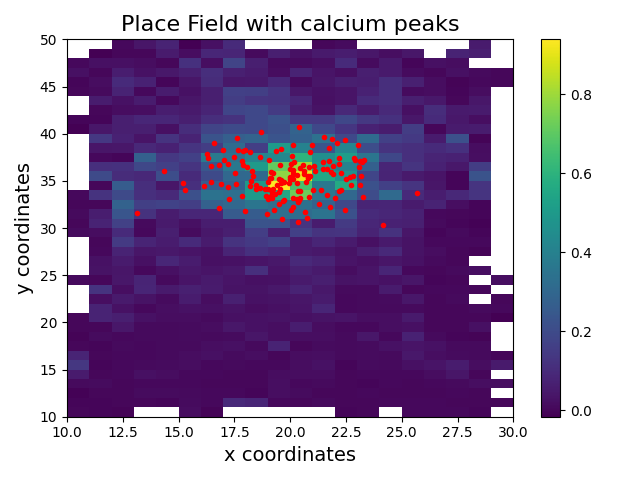

In [68]:


plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'])
plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



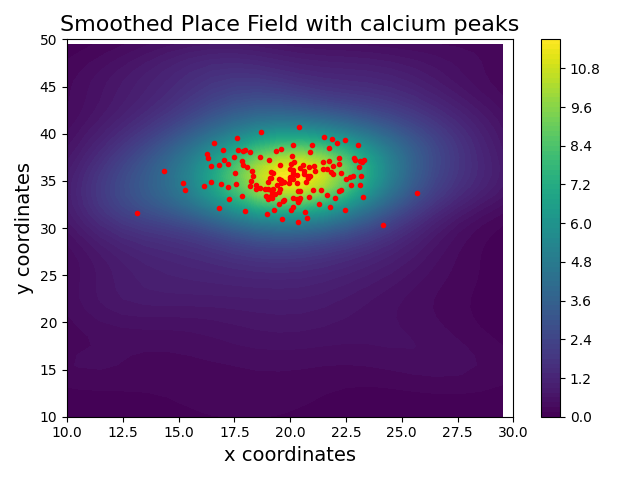

In [79]:


plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100,cmap='viridis')
plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()

plt.show()



In [7]:
place_cell_output.keys()

dict_keys(['place_field', 'place_field_smoothed', 'place_field_shuffled', 'place_field_smoothed_shuffled', 'mutual_info_distribution', 'mutual_info_distribution_bezzi', 'mutual_info_distribution_shuffled', 'mutual_info_distribution_bezzi_shuffled', 'occupancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'events_amplitude', 'place_field_identity', 'num_of_islands', 'islands_x_max', 'islands_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'mutual_info_kullback_leibler_original', 'mutual_info_kullback_leibler_shuffled', 'mutual_info_kullback_leibler_zscored', 'mutual_info_kullback_leibler_centered', 'mutual_info_NN_original', 'mutual_info_NN_shuffled', 'mutual_info_NN_zscored', 'mutual_info_NN_centered', 'mutual_info_skaggs_original', 'mutual_info_skaggs_shuffled', 'mutual_in

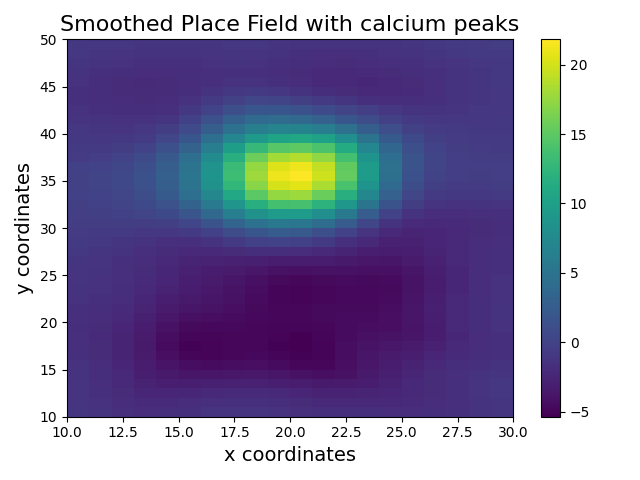

In [80]:

mean_place_field_shuffled = np.nanmean(place_cell_output['place_field_smoothed_shuffled'],0)
std_place_field_shuffled = np.nanstd(place_cell_output['place_field_smoothed_shuffled'],0)
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_smoothed_zscored = (place_field_smoothed - mean_place_field_shuffled)/std_place_field_shuffled


plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_field_smoothed_zscored)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




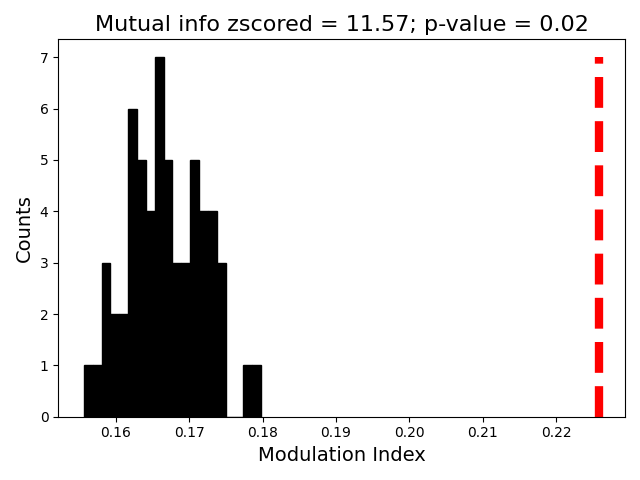

In [81]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shuffled'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shuffled'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


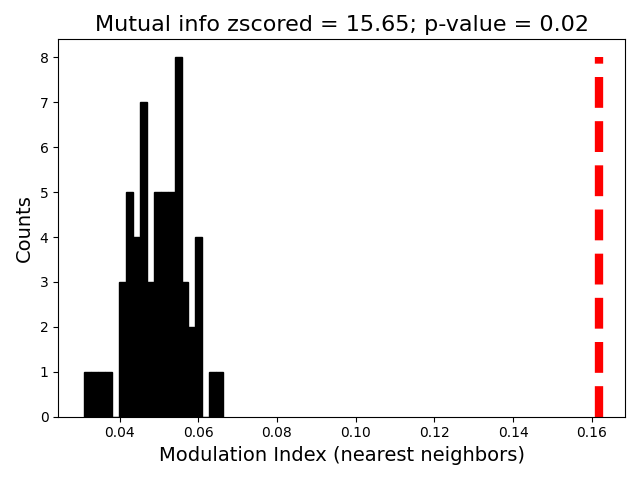

In [82]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_NN_shuffled'] >= place_cell_output['mutual_info_NN_original'])/place_cell_output['mutual_info_NN_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_NN_shuffled'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_NN_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_NN_original'],place_cell_output['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


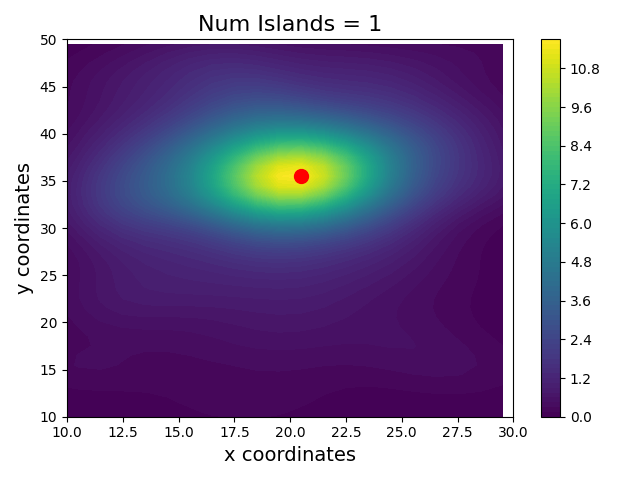

In [84]:
# place field identity and location

plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100)
plt.colorbar()
plt.plot(place_cell_output['x_center_bins'][place_cell_output['islands_x_max']],place_cell_output['y_center_bins'][place_cell_output['islands_y_max']],color='red',linestyle='',marker='.',markersize=20)
plt.title('Num Islands = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


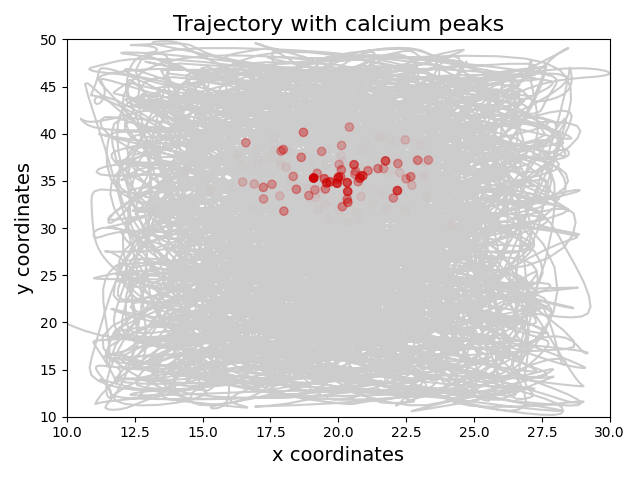

In [85]:

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


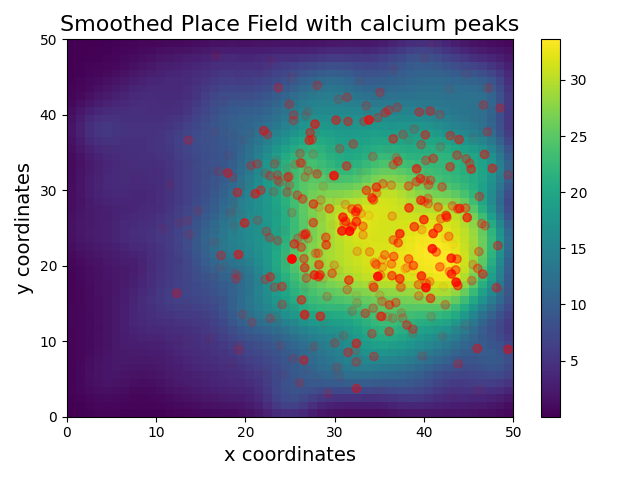

In [19]:
x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


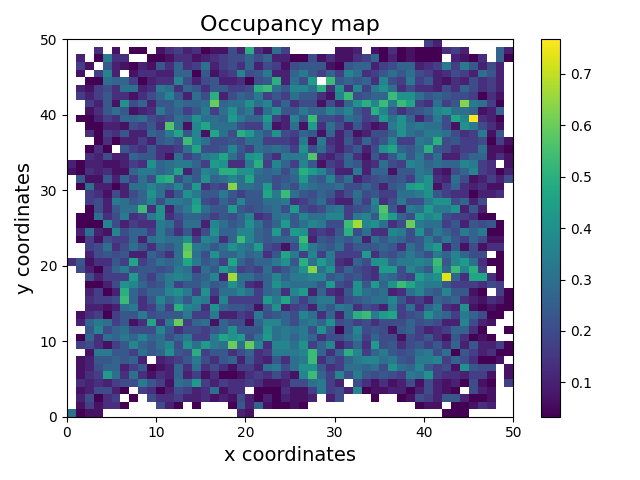

In [21]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['occupancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


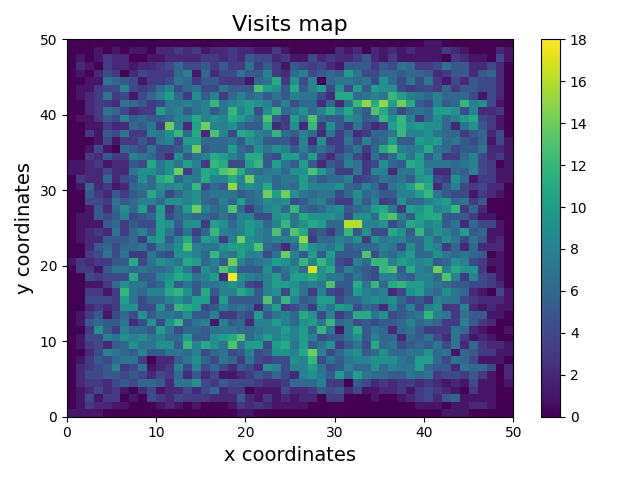

In [22]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


In [16]:
place_cell_output.keys()

dict_keys(['place_field', 'place_field_smoothed', 'place_field_shuffled', 'place_field_smoothed_shuffled', 'occupancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'events_amplitude', 'num_of_islands', 'islands_x_max', 'islands_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'mutual_info_kullback_leibler_original', 'mutual_info_kullback_leibler_shuffled', 'mutual_info_kullback_leibler_zscored', 'mutual_info_kullback_leibler_centered', 'mutual_info_NN_original', 'mutual_info_NN_shuffled', 'mutual_info_NN_zscored', 'mutual_info_NN_centered', 'mutual_info_skaggs_original', 'mutual_info_skaggs_shuffled', 'mutual_info_skaggs_zscored', 'mutual_info_skaggs_centered', 'input_parameters'])

In [21]:
# Surrogate procedure demonstration - take the signal above, shuffle it and check if it is significant (it shouldn't)

# https://www.sciencedirect.com/science/article/pii/S0370157318301340

# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
srate = 1/np.nanmean(np.diff(timevector))

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 
input_dict['x_bin_size'] = 1# y bin size in cm
input_dict['y_bin_size'] = 1# y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shift_time'] = 200
input_dict['num_cores'] = 30
input_dict['num_surrogates'] = 200
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['smoothing_size'] = 2
input_dict['nbins_cal'] = 10
input_dict['percentile_threshold'] = 95
input_dict['min_num_of_pixels'] = 4

place_cell_shuff = pl.PlaceCell(**input_dict)

calcium_imag_shuffled = place_cell_shuff.get_surrogate(calcium_imag,shift_time=200,mean_video_srate = srate)

place_cell_output_shuff = place_cell_shuff.main(calcium_imag_shuffled,timevector,x_coordinates,y_coordinates)


/home/apolo/Documents/GitHubProjects/Information_Metrics/spatial_metrics/spatial_metrics_base.py:271: RuntimeWarning: Mean of empty slice
  place_field[yy, xx] = np.nanmean(calcium_imag[np.logical_and(check_x_occupancy, check_y_occupancy)])
/home/apolo/Documents/GitHubProjects/Information_Metrics/spatial_metrics/spatial_metrics_base.py:397: RuntimeWarning: invalid value encountered in log
  observed_distr = -np.nansum((mean_calcium_activity / np.nansum(mean_calcium_activity)) * np.log(
/home/apolo/Documents/GitHubProjects/Information_Metrics/spatial_metrics/spatial_metrics_base.py:419: RuntimeWarning: invalid value encountered in log2
  mutual_info_skaggs = np.nansum((bin_probability * (mean_calcium_activity / overall_mean_amplitude)) * np.log2(


SpatialMetrics.Raw.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


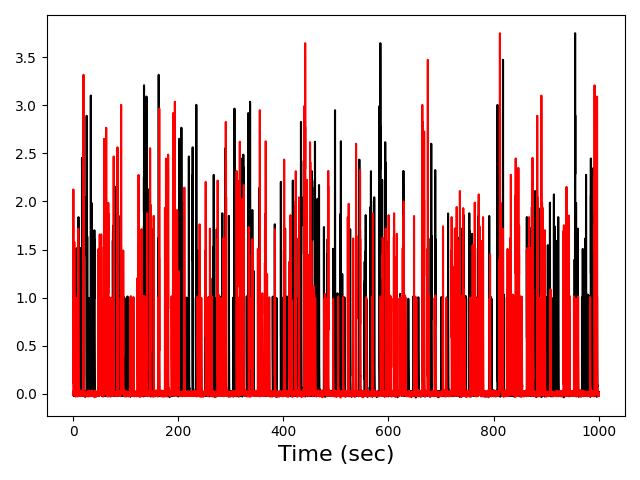

In [22]:

plt.figure()
plt.plot(timevector,calcium_imag,'k')
plt.plot(timevector,calcium_imag_shuffled,'r')
plt.xlabel('Time (sec)', fontsize=16)
plt.tight_layout()
plt.show()

# os.chdir(path + '/figures/')
# plt.savefig('Surrogate_Trace_Example{0}.svg'.format(surr))


TypeError: unsupported format string passed to numpy.ndarray.__format__

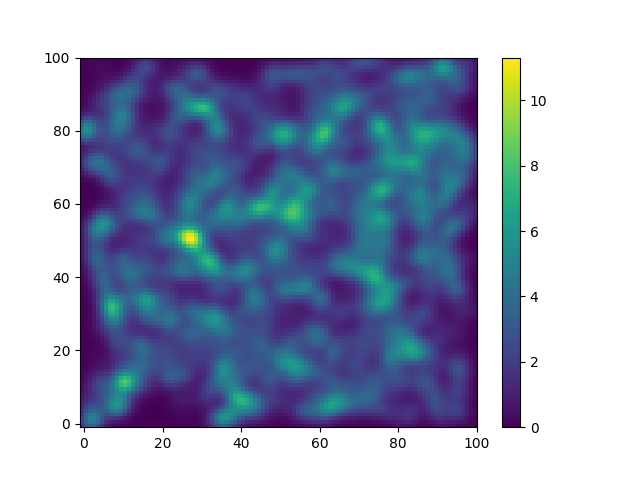

In [23]:

plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'])
plt.colorbar()
plt.title('Num Islands = {0};\n Extension abs = {1:0.2f};\n Extension relative = {2:0.2f}'.format(place_cell_output_shuff['num_of_islands'],place_cell_output_shuff['place_cell_extension_absolute'],place_cell_output_shuff['place_cell_extension_relative']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



x_peaks_location = place_cell_output_shuff['x_peaks_location']
y_peaks_location = place_cell_output_shuff['y_peaks_location']

events_amplitude = place_cell_output_shuff['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


x_peaks_location = place_cell_output_shuff['x_peaks_location']
y_peaks_location = place_cell_output_shuff['y_peaks_location']

events_amplitude = place_cell_output_shuff['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Place field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['ocuppancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()





plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()

# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_skaggs_shuffled'] >= place_cell_output_shuff['mutual_info_skaggs_original'])/place_cell_output_shuff['mutual_info_skaggs_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['mutual_info_skaggs_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_skaggs_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_skaggs_original'],place_cell_output_shuff['mutual_info_skaggs_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['mutual_info_skaggs_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (Skaggs)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_NN_shuffled'] >= place_cell_output_shuff['mutual_info_NN_original'])/place_cell_output_shuff['mutual_info_NN_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['mutual_info_NN_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_NN_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_NN_original'],place_cell_output_shuff['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_shuffled'] >= place_cell_output_shuff['mutual_info_original'])/place_cell_output_shuff['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_original'],place_cell_output_shuff['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (mutual information)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['kullback_leibler_mod_index_shuffled'] >= place_cell_output_shuff['kullback_leibler_mod_index'])/place_cell_output_shuff['kullback_leibler_mod_index_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['kullback_leibler_mod_index_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['kullback_leibler_mod_index_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['kullback_leibler_mod_index'],place_cell_output_shuff['kullback_leibler_mod_index']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mod Index zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['kullback_leibler_mod_index_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (Kullback Leibler normalized)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()



